<a href="https://colab.research.google.com/github/mellonmusk/cs231n/blob/master/assignment_solution/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/assignment1/cs231n/datasets
/content/drive/My Drive/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.376492
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)?

$\color{blue}{\textit Your Answer:}$  

The w's are initialized as small values so almost all S~= zeros and   
-log((e^Sj)/sum(e^Sj's)) = -log(1/10)


Also, we are going to choose from 10 classes, and the probability of choosing the correct class is 0.1. Initially all classes can be chosen equally.

In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.807718 analytic: -0.807718, relative error: 3.963467e-08
numerical: -0.401021 analytic: -0.401021, relative error: 5.380227e-09
numerical: 3.285952 analytic: 3.285952, relative error: 1.084672e-08
numerical: -2.150479 analytic: -2.150479, relative error: 3.119681e-08
numerical: 3.329294 analytic: 3.329294, relative error: 2.037063e-08
numerical: 0.671853 analytic: 0.671853, relative error: 3.534603e-08
numerical: 2.797766 analytic: 2.797766, relative error: 9.924186e-09
numerical: -1.959684 analytic: -1.959684, relative error: 4.848078e-09
numerical: 1.002100 analytic: 1.002100, relative error: 2.977372e-08
numerical: -0.865070 analytic: -0.865070, relative error: 5.481580e-08
numerical: -3.051758 analytic: -0.642704, relative error: 6.520718e-01
numerical: -3.051758 analytic: -1.622839, relative error: 3.056774e-01
numerical: -3.051758 analytic: -0.465272, relative error: 7.354178e-01
numerical: -3.051758 analytic: -2.790941, relative error: 4.463980e-02
numerical: -3.05


<h3>Explanation of the naive implementation</h3>

```
num_train = X.shape[0]
    num_classes = W.shape[1]
    for i in range(num_train):
      softmax = np.exp(stable_scores[i])/np.sum(np.exp(stable_scores[i]))
      loss += -np.log(softmax[y[i]])
      for j in range(num_classes):
        dW[:, j] += X[i] * softmax[j]
      dW[:,y[i]] -= X[i]

```


<h3>Explanation of the naive implementation</h3>

```
num_train = X.shape[0]
    num_classes = W.shape[1]
    for i in range(num_train):
      softmax = np.exp(stable_scores[i])/np.sum(np.exp(stable_scores[i]))
      loss += -np.log(softmax[y[i]])
      for j in range(num_classes):
        dW[:, j] += X[i] * softmax[j]
      dW[:,y[i]] -= X[i]

```
What we need to calculate : $$ {∂L_i\over∂W_{ij}} = {∂L_i\over∂f{ij}} * {∂f{ij}\over∂W{ij}} $$  
Also, score = XW so
$$ {∂f{ij}\over∂W{kj}} = ∂X_{ik} $$
Let score as f for short.  

$$L_i = -log(softmax({f_{i{y_i}}}))$$

$${∂L_i\over∂f{ij}}=-{1\over softmax({f_{i{y_i}}})}*{∂softmax({f_{i{y_i}}})\over∂f{ij}}$$

Now we need to calculate this first.

$$∂softmax({f_{i{y_i}}})\over∂f{ij}$$   

$$ (j=y_i)
 { e^{f_{i{y_i}}}∑-e^{f_{i{y_i}}}e^{f_{i{y_i}}}\over∑^2 }
 \\={e^{f_{i{y_i}}}\over∑} * {∑-e^{f_{i{y_i}}}\over∑}
 \\=softmax(f_{ij})(1-softmax(f_{ij}))
$$

$$ (j\ne{y_i})
  { 0-e^{f_{i{y_i}}}e^{f_{ij}}\over∑^2 }
  \\=-softmax(f_{i{y_i}})softmax(f_{ij})
$$  

Therefore,
$${∂L_i\over∂f{ij}} =
\begin{cases}
(j=y_i)\ softmax(f_{ij})-1
\\
(j\ne{y_i})\ softmax(f_{ij})-0
\end{cases}
$$   


Now we have
$$
{∂L_i\over∂W_{ij}} =
\begin{cases}
(j=y_i)\ X_{ij}(softmax(f_{ij})-1)
\\
(j\ne{y_i})\ X_{ij}(softmax(f_{ij}))
\end{cases}
$$

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 3.094899e+04 computed in 0.087023s
vectorized loss: 2.376492e+00 computed in 0.011745s
Loss difference: 30946.612353
Gradient difference: 0.000000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2e3, 2.5e3, 4e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

softmax = Softmax()

test_case = [(lr,rs) for lr in learning_rates for rs in regularization_strengths]

for lr, rs in test_case:
  softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=1000, verbose=True)

  train_pred = softmax.predict(X_train)
  train_accuracy = np.mean(train_pred == y_train)

  val_pred = softmax.predict(X_val)
  val_accuracy = np.mean(val_pred == y_val)

  if best_val < val_accuracy:
    best_val = val_accuracy
    best_softmax = softmax

  results[(lr, rs)] = (train_accuracy, val_accuracy)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 69.111278
iteration 100 / 1000: loss 60.885133
iteration 200 / 1000: loss 55.894038
iteration 300 / 1000: loss 51.366940
iteration 400 / 1000: loss 47.410741
iteration 500 / 1000: loss 43.576698
iteration 600 / 1000: loss 40.293533
iteration 700 / 1000: loss 37.372094
iteration 800 / 1000: loss 34.424793
iteration 900 / 1000: loss 32.037558
iteration 0 / 1000: loss 36.295661
iteration 100 / 1000: loss 33.193122
iteration 200 / 1000: loss 30.201078
iteration 300 / 1000: loss 27.360210
iteration 400 / 1000: loss 24.898123
iteration 500 / 1000: loss 22.530783
iteration 600 / 1000: loss 20.622542
iteration 700 / 1000: loss 18.794368
iteration 800 / 1000: loss 17.321166
iteration 900 / 1000: loss 15.644516
iteration 0 / 1000: loss 201.242519
iteration 100 / 1000: loss 42.073165
iteration 200 / 1000: loss 10.108790
iteration 300 / 1000: loss 3.702928
iteration 400 / 1000: loss 2.466785
iteration 500 / 1000: loss 2.213070
iteration 600 / 1000: loss 2.187113
iteration 

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.319000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$  
true

$\color{blue}{\textit Your Explanation:}$  
Example case for such condition:  
When the SVM loss was 0, adding datapoint that has scores as [1,2,6] as a new datapoint(correct class is 2, score is 6 in this case) would not change the SVM loss.  
max(0, 1-6+1)=0, max(2-6+1)=0

However the Softmax classifier loss changes.  
-log(softmax(6)) = 0.01


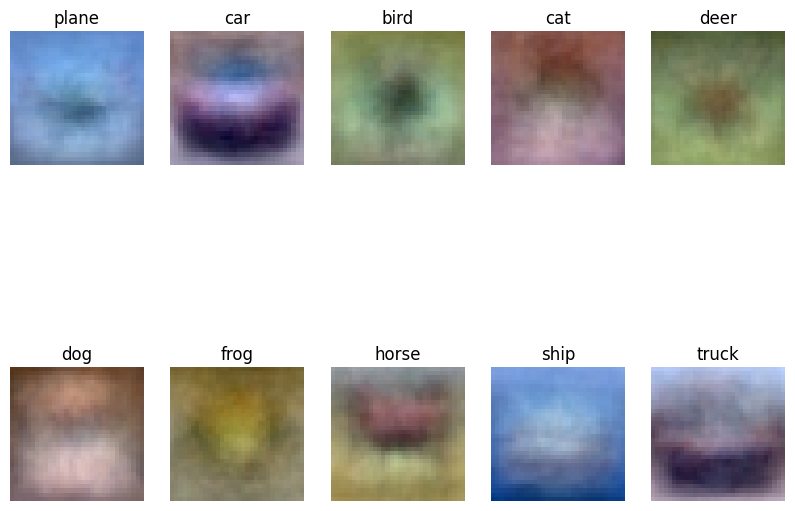

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])